# Семинар 5 - Композиции алгоритмов

In [63]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(palette='deep', style='darkgrid', rc={"figure.figsize": (15, 4)})
import scipy.stats as st

import warnings
warnings.simplefilter('ignore')

In [64]:
# Загрузим данные и проведем предобработки: 
data = pd.read_csv('../data/flight_delays_train.csv')
data['dep_delayed_15min'] = data['dep_delayed_15min'].apply(lambda x: 1 if x == 'Y' else 0)
data['Month'] = data['Month'].str.replace('c-', '').astype('int16')
data['DayofMonth'] = data['DayofMonth'].str.replace('c-', '').astype('int16')
data['DayOfWeek'] = data['DayOfWeek'].str.replace('c-', '').astype('int16')
data['UniqueCarrier'] = pd.factorize(data['UniqueCarrier'])[0]
data['Origin'] = pd.factorize(data['Origin'])[0]
data['Dest'] = pd.factorize(data['Dest'])[0]

# DepTime пусть бдет более вещественным числом (так как 60 минут в часах)
data['DepTime_real'] = data['DepTime'].apply(lambda x: int(x/100)+((x/100-int(x/100))*100)/59)
data.drop('DepTime', axis=1, inplace=True)


x = data.drop('dep_delayed_15min', axis=1)
y = data['dep_delayed_15min'].values


data.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min,DepTime_real
0,8,21,7,0,0,0,732,0,19.576271
1,4,20,3,1,1,1,834,0,15.813559
2,9,2,5,2,2,2,416,0,14.372881
3,11,25,6,3,3,3,872,0,10.254237
4,10,7,6,4,4,4,423,1,18.474576


# Bootstrap
Посмотрим плотности распредления переменной "Время Вылета" для задержки менее 15 минут и более

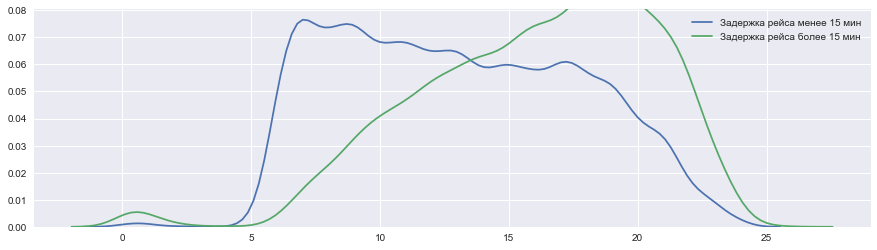

In [65]:
sns.kdeplot(data[data['dep_delayed_15min'] == 0]['DepTime_real'], label='Задержка рейса менее 15 мин')
sns.kdeplot(data[data['dep_delayed_15min'] == 1]['DepTime_real'], label='Задержка рейса более 15 мин')
plt.legend()
plt.show()

In [66]:
print('Среднее', data[data['dep_delayed_15min'] == 1]['DepTime_real'].mean())
print('Среднее', data[data['dep_delayed_15min'] == 0]['DepTime_real'].mean())

Среднее 16.011120545106937
Среднее 13.058375924649887


In [67]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [68]:
# сохранение в отдельные numpy массивы данных по вылетам с задержками и без 
no_delayed = data[data['dep_delayed_15min'] == 0]['DepTime_real'].values
delayed = data[data['dep_delayed_15min'] == 1]['DepTime_real'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем 1000 выборок с помощью бутстрэпа и сразу считаем по каждой из них среднее
no_delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(no_delayed, 1000)]
delayed_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(delayed, 1000)]

In [69]:
#  выводим интервальную оценку среднего
print("Среднее время вылета по рейсам без задержек в интервале:",  stat_intervals(no_delayed_mean_scores, 0.05))
print("Среднее время вылета по рейсам с задержками в интервале:",  stat_intervals(delayed_mean_scores, 0.05))

Среднее время вылета по рейсам без задержек в интервале: [13.02623288 13.08874223]
Среднее время вылета по рейсам с задержками в интервале: [15.94721421 16.07553438]


Sub-sampling (_pasting_) тоесть выборка без повторений - достойная альтернатива

# Bagging (Bootstrap aggregating)

In [70]:
from sklearn.ensemble import BaggingClassifier, BaggingRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import roc_auc_score, accuracy_score

In [71]:
tree = DecisionTreeClassifier()
bag_of_trees = BaggingClassifier(tree, n_estimators=20)

In [72]:
# Посчитаем значение метрики accuracy на кроссвалидаци для дерева
np.mean(cross_val_score(tree, x, y, cv=3, scoring='accuracy'))

0.7279800175454204

In [73]:
# Посчитаем значение метрики accuracy на кроссвалидаци для композиции деревьев построенной на бутстрап выборке
np.mean(cross_val_score(bag_of_trees, x, y, cv=3, scoring='accuracy'))

0.8148799931630443

### Out-of-bag error

На каждом шаге все объекты попадают в подвыборку с возвращением равновероятно, значит:  
Вероятность, что объект попадет в выборку: $ \frac {1}{l}$   

Вероятность, что объект не попадет в выборку: $ 1-\frac {1}{l}$    
  
Так как мы тянем $l$ раз, то  вероятность, что объект не попадет во всю выборку: $ \bigl( 1-\frac {1}{l} \bigr) ^l$ 

Значит, при  $l \rightarrow \infty$ что вероятность, что объект не поппадает в выборку: $ \frac {1}{e} \approx 0.37 $      
  
__Вывод:__ При формировании Bootstrap выборки в нее попадает только __63%__ объектов   
__Свойство:__ Можно вычислять Out-of-bag error и не проводить кроссвалидацию

In [74]:
tree = DecisionTreeClassifier()
bag_of_trees = BaggingClassifier(tree, n_estimators=20, oob_score=True, n_jobs=-1)

In [75]:
bag_of_trees.fit(x,y)
bag_of_trees.oob_score_

0.80315

## Как можно добавить случайности? 

Например: Ограничить кол-во признаков, по которым проводить разбиение

In [85]:
tree = DecisionTreeClassifier(max_features=4)
bag_of_trees = BaggingClassifier(tree, n_estimators=20, oob_score=True, n_jobs=-1)

bag_of_trees.fit(x,y)
bag_of_trees.oob_score_

0.80437

Почему это работает, и зачем нам нужна случайность?

# Случайный лес

In [86]:
forest = RandomForestClassifier(n_estimators=20, n_jobs=-1)
np.mean(cross_val_score(forest, x,y, cv=3, n_jobs=-1, scoring='accuracy'))

0.8139300022627634




### Что будет, если ограничить глубину построенных деревьев? 

In [78]:
#Разделим выборку на обущающую и тестовую
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, \
                                                    shuffle=True, random_state=21)

In [118]:
train_score = []
test_score = []


for i in range(1,16):
    forest = RandomForestClassifier(n_estimators=10, n_jobs=-1, max_depth=i, min_samples_leaf=50)
    forest.fit(x_train, y_train)
    train_score = np.append(train_score, accuracy_score(y_train, forest.predict(x_train)))
    test_score = np.append(test_score, accuracy_score(y_test, forest.predict(x_test)))

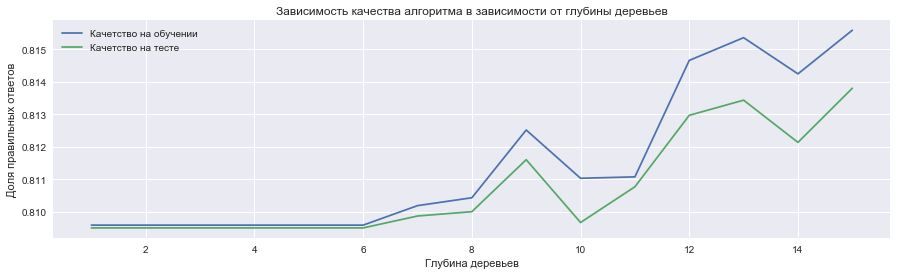

In [137]:
plt.title('Зависимость качества алгоритма в зависимости от глубины деревьев')
plt.plot(range(1,16), train_score, label="Качетство на обучении")
plt.plot(range(1,16), test_score, label="Качетство на тесте")
plt.legend()
plt.ylabel('Доля правильных ответов')
plt.xlabel('Глубина деревьев')
plt.show()

### Важность признкаов
Одно из замечательных свойств, что можно посмотреть важность каждого признака, оценив вклад 

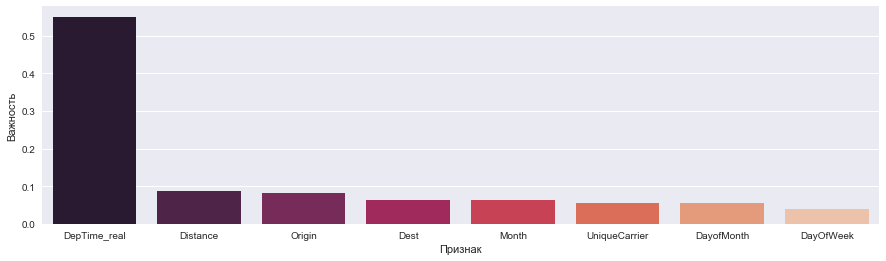

In [139]:
feature_importances = pd.DataFrame(forest.feature_importances_, index=x_train.columns, columns=['Importance']
            ).sort_values('Importance', ascending=False)

sns.barplot(y=feature_importances['Importance'], x=feature_importances.index, palette="rocket")
plt.ylabel('Важность')
plt.xlabel('Признак')
plt.show()